# Clustering Birdsong

By [William Jenkins](https://github.com/NeptuneProjects)  
Scripps Institution of Oceanography, UC San Diego

This notebook demonstrates how to use a deep convolutional autoencoder to 1) reduce the dimensionality of audio data and 2) perform clustering.
The data set used in this notebook consists of recordings from five species of North American birds, and was assembled from the [xeno-canto](https://www.xeno-canto.org/) database by [Vinay Shanbhag](https://www.kaggle.com/datasets/vinayshanbhag/bird-song-data-set).

## Setup

### Download the data

> [!NOTE]
> Data are not included in the `AcousticsML` repository due to its size (over 2.4 GB). To access the data, follow the instructions below.

The data used in this notebook are available from the [Kaggle](https://www.kaggle.com) website; an account is required to access the data.
Once you have an account, you can download the data set from [this link](https://www.kaggle.com/datasets/vinayshanbhag/bird-song-data-set).

1. Download the data as a `.zip` file from the [Kaggle website]((https://www.kaggle.com/datasets/vinayshanbhag/bird-song-data-set)).
2. Unzip the contents and move them to the `./3_5_data` directory in the `AcousticsML` repository.

Once downloaded and unzipped, the directory structure should look like this:
```raw
AcousticsML/
├── 3_5_data/
│   ├── wavfiles/
│   │   ├── 11713-0.wav
│   │   ├── 11713-1.wav
|   |   └── ...
│   └── bird_songs_metadata.csv
└── 3_5_notebook.ipynb
```

### Import libraries

In [1]:
from pathlib import Path
from typing import Any

from IPython import display
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchaudio
import torchaudio.transforms as transforms
from torchvision.transforms import Compose
from tqdm.notebook import tqdm

### Set data path and get the `.wav` files

In [2]:
dataset_path = Path.cwd() / "3_5_data" / "wavfiles"
file_list = list(dataset_path.glob("*.wav"))

output_path = Path.cwd() / "3_5_data" / "output"
output_path.mkdir(parents=True, exist_ok=True)

### Select device (CPU or GPU)

Neural networks can be trained on a CPU or a GPU.
The latter is much faster, but requires a compatible GPU.
If you have a GPU, you can enable it by setting `device` to `"cuda"`.
Otherwise, set it to `"cpu"`.

Apple computers do not support CUDA, but PyTorch now ships with the Metal Performance Shaders (MPS) backend for accelerated training on macOS.
To enable it, set `device` to `"mps"`.

In most cases, `CUDA` will be the fastest option, followed by `MPS`, and finally `CPU`.

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

Using device: mps


## Part I: Train a convolutional autoencoder

In this section, we will train a convolutional autoencoder to learn an embedded representation of the audio data.
The autoencoder will consist of an encoder that takes spectrograms of the audio files and encodes them into a lower-dimensional representation (the latent space, a.k.a. embeddings), and a decoder that reconstructs the original data from this representation.

For simplicity, this workflow does not include hyperparameter tuning, but you can easily modify the code to include it.
There is also no test or validation set in this workflow, so the model will be trained on the entire dataset.
The reason for this is that the goal is to learn a representation of the data, not to classify it in a generalized setting.

### Define a helper function to visualize data

This function will be used to visualize the input, bottleneck, and output of the autoencoder during and after training.

In [4]:
def plot_input_output(
    x: torch.tensor,
    z: torch.tensor,
    x_r: torch.tensor,
    index: int = 0,
    fig: plt.Figure = None,
    title=None,
) -> plt.Figure:
    """
    Plot the input spectrogram, latent embeddings, and reconstructed spectrogram.

    Args:
        x: Input spectrogram tensor ([batch_size, channels, freq_bins, time_bins]).
        z: Latent embeddings tensor  ([batch_size, channels, 1]).
        x: Reconstructed spectrogram tensor  ([batch_size, channels, freq_bins, time_bins]).
        index: Index of which sample from the batch to plot.
        fig: Existing figure to use for plotting.
        title: Title for the plot.

    Returns:
        fig: The matplotlib figure containing the plots.
    """
    subplot_kwargs = {
        "ncols": 3,
        "gridspec_kw": {"width_ratios": [1, 0.1, 1], "hspace": 0.5},
    }
    if fig is None:
        fig, axs = plt.subplots(figsize=(12, 4), **subplot_kwargs)
    else:
        axs = fig.subplots(**subplot_kwargs)

    # Plot the original spectrogram
    ax = axs[0]
    ax.imshow(
        x[index].detach().cpu().numpy().squeeze(),
        aspect="auto",
        origin="lower",
        cmap="plasma",
    )
    ax.set_xlabel("Time bins")
    ax.set_ylabel("Frequency bins")
    ax.set_title("Original Spectrogram")

    # Plot the latent space embeddings
    ax = axs[1]
    ax.imshow(
        z[index].detach().cpu().numpy()[..., np.newaxis], aspect="auto", origin="lower"
    )
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_title("Latent Embeddings")

    # Plot the reconstructed spectrogram
    ax = axs[2]
    ax.imshow(
        x_r[index].detach().cpu().numpy().squeeze(),
        aspect="auto",
        origin="lower",
        cmap="plasma",
    )
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_xlabel("Time bins")
    ax.set_ylabel("Frequency bins")
    ax.set_title("Reconstructed Spectrogram")

    # Connect the two subplots with an arrow:
    con1 = ConnectionPatch(
        xyA=(1.01, 0.5),
        xyB=(-0.1, 0.5),
        coordsA="axes fraction",
        coordsB="axes fraction",
        axesA=axs[0],
        axesB=axs[1],
        color="black",
        arrowstyle="-|>",
        mutation_scale=20,
    )
    con2 = ConnectionPatch(
        xyA=(1.1, 0.5),
        xyB=(-0.01, 0.5),
        coordsA="axes fraction",
        coordsB="axes fraction",
        axesA=axs[1],
        axesB=axs[2],
        color="black",
        arrowstyle="-|>",
        mutation_scale=20,
    )
    fig.add_artist(con1)
    fig.add_artist(con2)
    fig.suptitle(title)
    return fig

### Define a custom Dataset class for loading birdsong data

To simplify the process of loading the birdsong data, we define a custom Dataset class that inherits from PyTorch's Dataset class.
This class will load the audio files and their corresponding labels.
Adapting the `Dataset` class is a convenient way to handle data pipelines, as it allows for standard and custom data transformations. Furthermore, the `Dataset` class is accepted by the PyTorch `Dataloader` class, which is rather efficient in terms of memory usage and speed.

Data in the birdsong dataset are already normalized between $[-1, 1]$.
However, if further transformations are needed, they can be supplied to the `__init__` method with the `transform` argument.
For example, in a subsequent step, we will supply a callable that transforms the time series to a spectrogram.

When defining a custom `Dataset` class, three dunder methods must be implemented. We adapt them to accomplish specific tasks for our use case:
- `__init__`: Initialize the dataset, load the audio files, and store the labels.
- `__len__`: Return the number of samples in the dataset.
- `__getitem__`: Return a sample from the dataset at a given index, including the audio data and its corresponding label.

Note that the `__getitem__` method returns a tuple containing the transformed (if applicable) audio data and its sampling rate.
The latter is not needed for the autoencoder, but it is useful for signal processing and visualization.

In the custom `AudioDataset` below, two approaches to loading the data are available as set by the `preload` argument.
- If `preload` is set to `True`, all audio files are loaded into memory when the dataset is initialized.
This leads to faster model training but requires more memory.
- If `preload` is set to `False`, the audio files are loaded on-the-fly when requested.
This is slower but requires less memory, but can be [accelerated using multiple processors](https://pytorch.org/docs/stable/data.html#multi-process-data-loading) as set by `num_workers` in the `DataLoader` class.

For now, we don't need the entire dataset, so we will not preload it.
Later, we will set `preload` to `True` to speed up the training process since the dataset isn't too large.

In [5]:
class AudioDataset(Dataset):
    def __init__(
        self,
        file_list: list[Path],
        transform: Any | None = None,
        device: str = "cuda",
        preload: bool = False,
    ) -> None:
        """Initialize the AudioDataset with optional preloading to GPU memory.

        Args:
            file_list: List of audio file paths.
            transform: Optional transformation to apply to the audio data.
            device: Device to store/move the data to (e.g., "cpu", "cuda", "mps").
            preload: Whether to preload all data to memory (True) or load on demand (False).
        """
        self.file_list = file_list
        self.transform = transform
        self.device = device
        self.preload = preload

        # For preloaded mode
        self.audio_data = []
        self.sample_rates = []

        # Preload all files if requested
        if self.preload:
            print(f"Preloading {len(file_list)} audio files to {device}...")

            for i, audio_file in enumerate(self.file_list):
                if i % 1000 == 0 and i > 0:
                    print(f"Loaded {i}/{len(file_list)} files...")

                # Load and process audio
                audio, sr = self._load_and_process(audio_file)
                # Store in memory
                self.audio_data.append(audio)
                self.sample_rates.append(sr)

            print(f"Successfully loaded {len(self.audio_data)} audio files to {device}")

    def _load_and_process(self, audio_file: Path) -> tuple[torch.Tensor, int]:
        """Helper method to load and process a single audio file.

        Args:
            audio_file: Path to the audio file.

        Returns:
            Tuple of (processed_audio_tensor, sample_rate)
        """
        # Load audio
        audio, sr = torchaudio.load(audio_file)
        # Apply transform if provided
        if self.transform:
            audio = self.transform(audio)
        # Move to device
        return audio.to(self.device), sr

    def __len__(self) -> int:
        return len(self.file_list)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        """Get an audio sample.

        If preloaded, retrieves from memory. Otherwise, loads from disk.

        Args:
            idx: Index of the audio file to load.

        Returns:
            A tuple containing the audio data tensor and its sample rate.
        """
        if self.preload:
            # Return preloaded data
            return self.audio_data[idx], self.sample_rates[idx]
        else:
            # Load on demand
            audio_file = self.file_list[idx]
            return self._load_and_process(audio_file)

### Load and visualize raw data

We will define the dataset and can obtain the audio data by indexing into it.
To plot the data, first we need to convert it from a PyTorch tensor to a NumPy array.
Then we can use `matplotlib` to visualize the audio waveform.

To view different signals, change the value of `sample_index` below.

Data shape: torch.Size([1, 66150])
Sample rate: 22050 Hz
Data is on device: mps:0


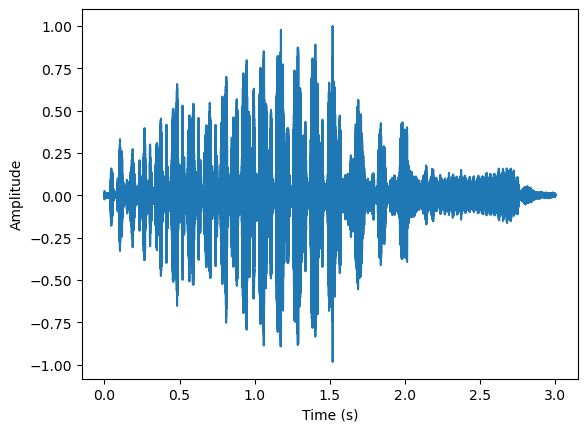

In [6]:
sample_index: int = 0

dataset = AudioDataset(file_list, device=device)
data, sampling_rate = dataset[sample_index]
print(f"Data shape: {data.shape}")
print(f"Sample rate: {sampling_rate} Hz")
print(f"Data is on device: {data.device}")

# Define the time vector based on the sampling rate and number of samples
num_samples = data.shape[-1]
time_seconds = np.linspace(0, num_samples / sampling_rate, num_samples)

plt.figure()
plt.plot(time_seconds, data.cpu().numpy().squeeze())
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

### Transform data using a spectrogram

We can now view the raw audio data in the time domain.
However, to make use of both time and frequency features of the audio data, we will transform the audio data into a spectrogram.

Using the `torchvision.transforms` module, we can apply a series of transformations to the audio data.
For this notebook, we will chain the following transformations together:
1. Compute the spectrogram of the audio data.
2. Apply a logarithmic transformation to the spectrogram.
3. Normalize the spectrogram between zero and one.
This is a standard technique for neural network training, as it helps to numerically stabilize the training process and improve convergence.
PyTorch doesn't have an off-the-shelf function for this, so we supply an anonymous (lambda) function. 

Spectrogram shape: torch.Size([1, 129, 129])
Sample rate: 22050 Hz
Data is on device: mps:0


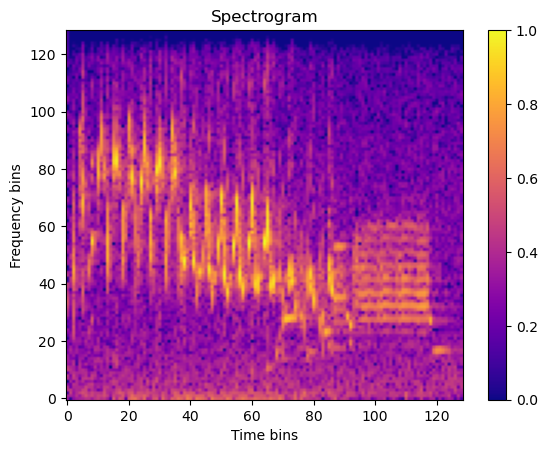

In [7]:
transform = Compose(
    [
        transforms.Spectrogram(n_fft=256, hop_length=514, power=2),
        transforms.AmplitudeToDB(stype="power", top_db=80),
        lambda x: (x - x.min()) / (x.max() - x.min() + 1e-10),
    ]
)
dataset = AudioDataset(file_list, transform=transform, device=device)
data, sample_rate = dataset[sample_index]
print(f"Spectrogram shape: {data.shape}")
print(f"Sample rate: {sampling_rate} Hz")
print(f"Data is on device: {data.device}")

plt.figure()
plt.imshow(
    data.cpu().numpy().squeeze(), aspect="auto", origin="lower", cmap="plasma"
)
plt.colorbar()
plt.title("Spectrogram")
plt.xlabel("Time bins")
plt.ylabel("Frequency bins")
plt.show()

### Define the autoencoder architecture

The autoencoder is a neural network that learns to encode input data (spectrograms) into a lower-dimensional representation and then reconstruct it back to the original input dimensions.
The implementation of the network here is symmetrical, but this is not a requirement.

The autoencoder consists of two main parts:
1. **Encoder**: This part of the network compresses the input data into a lower-dimensional representation (the latent space).
2. **Decoder**: This part of the network reconstructs the input data from the lower-dimensional representation.
The encoder and decoder are both implemented as convolutional neural networks (CNNs), which are well-suited for processing image-like data such as spectrograms.

In [8]:
class ConvAutoencoder(nn.Module):
    def __init__(self, in_channels: int = 1, latent_dim: int = 10) -> None:
        super(ConvAutoencoder, self).__init__()

        # Create encoder and decoder using the separate methods
        self.encoder = self._build_encoder(in_channels)
        self.decoder = self._build_decoder(in_channels)

        self.latent_dim = latent_dim
        self.fc_encoder = None
        self.fc_decoder = None
        self.initialized = False

        # Store dimensions for proper reshaping
        self.feature_size = 1024  # Initial value, will be updated in forward pass
        self.downsampling_factor = 64

        # Apply Xavier uniform initialization to all existing layers
        self._initialize_weights()

    def _build_encoder(self, in_channels: int) -> nn.Sequential:
        """Build and return the encoder network"""
        return nn.Sequential(
            # Layer 1: [batch, in_channels, H, W] -> [batch, 32, H/2, W/2]
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            # Layer 2: [batch, 32, H/2, W/2] -> [batch, 64, H/4, W/4]
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            # Layer 3: [batch, 64, H/4, W/4] -> [batch, 128, H/8, W/8]
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            # Layer 4: [batch, 128, H/8, W/8] -> [batch, 256, H/16, W/16]
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            # Layer 5: [batch, 256, H/16, W/16] -> [batch, 512, H/32, W/32]
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            # Layer 6: [batch, 512, H/32, W/32] -> [batch, 1024, H/64, W/64]
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
        )

    def _build_decoder(self, in_channels: int) -> nn.Sequential:
        """Build and return the decoder network"""
        return nn.Sequential(
            # Layer 1: [batch, 1024, H/64, W/64] -> [batch, 512, H/32, W/32]
            nn.ConvTranspose2d(
                1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.GELU(),
            # Layer 2: [batch, 512, H/32, W/32] -> [batch, 256, H/16, W/16]
            nn.ConvTranspose2d(
                512, 256, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.GELU(),
            # Layer 3: [batch, 256, H/16, W/16] -> [batch, 128, H/8, W/8]
            nn.ConvTranspose2d(
                256, 128, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.GELU(),
            # Layer 4: [batch, 128, H/8, W/8] -> [batch, 64, H/4, W/4]
            nn.ConvTranspose2d(
                128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.GELU(),
            # Layer 5: [batch, 64, H/4, W/4] -> [batch, 32, H/2, W/2]
            nn.ConvTranspose2d(
                64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.GELU(),
            # Layer 6: [batch, 32, H/2, W/2] -> [batch, in_channels, H, W]
            nn.ConvTranspose2d(
                32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            # No activation on final layer
        )

    def _initialize_weights(self) -> None:
        """Apply Xavier uniform initialization to all layers"""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Forward pass through the autoencoder.
        
        Args:
            x: Input tensor of shape [batch_size, in_channels, height, width].
        Returns:
            A tuple containing:
            - Reconstructed output tensor of shape [batch_size, in_channels, height, width].
            - Latent representation tensor of shape [batch_size, latent_dim].
        """
        # Save original input dimensions
        original_shape = x.shape

        # Get the device of the input tensor
        device = x.device

        # Pass through encoder
        encoded = self.encoder(x)

        # Get current dimensions
        batch_size = encoded.size(0)
        feature_size = encoded.size(1)
        height = encoded.size(2)
        width = encoded.size(3)
        flat_size = feature_size * height * width

        # Initialize FC layers if not done already
        if not self.initialized:
            self.fc_encoder = nn.Linear(flat_size, self.latent_dim).to(device)
            self.fc_decoder = nn.Linear(self.latent_dim, flat_size).to(device)

            # Apply Xavier initialization
            nn.init.xavier_uniform_(self.fc_encoder.weight)
            nn.init.zeros_(self.fc_encoder.bias)
            nn.init.xavier_uniform_(self.fc_decoder.weight)
            nn.init.zeros_(self.fc_decoder.bias)

            # Store dimensions for future forward passes
            self.feature_size = feature_size
            self.encoder_height = height
            self.encoder_width = width

            self.initialized = True

        # Flatten the feature maps
        flattened = encoded.view(batch_size, -1)

        # Project to latent space
        z = self.fc_encoder(flattened)

        # Project back to feature map dimensions
        decoded_flat = self.fc_decoder(z)

        # Reshape to encoder output dimensions
        decoded_conv = decoded_flat.view(
            batch_size, self.feature_size, self.encoder_height, self.encoder_width
        )

        # Pass through decoder
        output = self.decoder(decoded_conv)

        # Ensure output dimensions match input dimensions
        if output.shape != original_shape:
            output = F.interpolate(
                output,
                size=(original_shape[2], original_shape[3]),
                mode="bilinear",
                align_corners=False,
            )

        return (
            output,
            z,
        )  # Return both the reconstructed image and the latent representation

### Initialize the autoencoder

In this step, we instantiate the autoencoder model, which allows us to view a summary of the architecture and how many trainable parameters are in the model.

We also define the loss function (mean squared error, MSE) and the optimizer (AdamW). Play with the optimizer learning rate to see how it affects the training process.

In [9]:
autoencoder = ConvAutoencoder(in_channels=1, latent_dim=32)
print(autoencoder)
trainable_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params:,}")

criterion = nn.MSELoss()
optimizer = optim.AdamW(autoencoder.parameters(), lr=0.0005)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU(approximate='none')
    (10): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): GELU(approximate='none')
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU(approximate='none')
    (2): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): GELU

### Train the autoencoder

The autoencoder is trained by training the network on mini-batches of data.
The training loop consists of the following steps:
1. Forward pass: The input data is passed through the autoencoder to obtain the output.
2. Compute the loss: The MSE loss is computed between the output and the input.
3. Backward pass: The gradients of the loss with respect to the weights are computed.
4. Update the weights: The optimizer updates the weights of the network using the gradients.
5. Repeat steps 1-4 for a set number of *epochs*.

The best model corresponds to the one with the lowest loss and is saved for future use.

The `AudioDataset` class is designed to handle large datasets efficiently by loading audio files on-the-fly, or by preloading the entire dataset into memory.
In the code below, we preload the entire dataset into memory by setting `preload=True` in the `AudioDataset` class.
If you get out-of-memory errors, set `preload` to `False`.

`DataLoader` accepts an argument `batch_size`, which specifies how many samples to load in each mini-batch.
This is a convenient way to feed batches of data to the autoencoder during training.
Batch size not only has implications on computing performance, but also on the model's performance.
For example, smaller batch sizes ensure that the model captures finer representations of the features within the data, but takes longer to train.
For plotting repeatability, we disable random shuffling in the dataloader.

The number of training epochs -- `num_epochs` -- can be adjusted to improve the model's performance.
A single epoch is one complete pass through the entire dataset.
For this notebook, we will train the model for 10 epochs, and you'll see at the end of this section that 10 epochs is not nearly enough training to capture the features of the audio data.
Increase the `num_epochs` variable to train the model for more epochs, sit back, and sip some coffee - you're now a machine learner!

Some visualizations of the training process are included to monitor the loss and the reconstructed audio data.

Preloading 9107 audio files to mps...
Loaded 1000/9107 files...
Loaded 2000/9107 files...
Loaded 3000/9107 files...
Loaded 4000/9107 files...
Loaded 5000/9107 files...
Loaded 6000/9107 files...
Loaded 7000/9107 files...
Loaded 8000/9107 files...
Loaded 9000/9107 files...
Successfully loaded 9107 audio files to mps


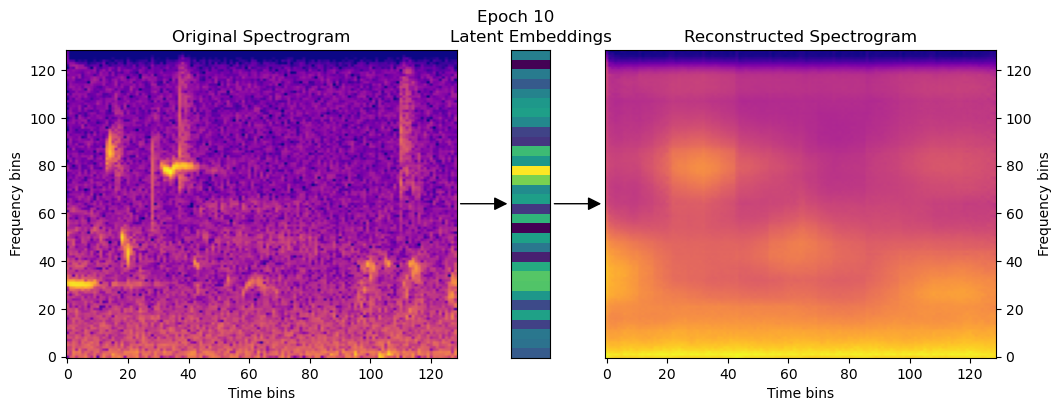

Epoch 1:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/143 [00:00<?, ?it/s]

In [10]:
dataset = AudioDataset(file_list, transform=transform, device=device, preload=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
autoencoder = autoencoder.to(device)
criterion = criterion.to(device)
num_epochs = 10

fig = plt.figure(figsize=(12, 4), num=10)
figdisplay = display.display("", display_id=True)

best_loss = torch.inf
mse = []
for epoch in range(num_epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")

    for x, _ in pbar:
        x_r, z = autoencoder(x)
        loss = criterion(x_r, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({"MSE": loss.item()})

    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(autoencoder.state_dict(), output_path / "best_model.pth")

    mse.append(loss.item())  # Store the loss for plotting later

    fig = plot_input_output(x, z, x_r, index=12, fig=fig, title=f"Epoch {epoch + 1}")
    figdisplay.update(fig)
    fig.savefig(output_path / f"epoch_{epoch + 1}.png")
    plt.clf()

plt.close(fig)

### Retrieve best autoencoder model

With training complete, we can now load the best model and use it to encode the data.
The model is placed in `eval` mode for inference (i.e., only the forward pass is performed).

In [11]:
autoencoder.load_state_dict(torch.load(output_path / "best_model.pth"))
autoencoder.eval();

### Visualize the autoencoder's performance

Let's see how the training progressed by plotting the mean squared error (MSE) loss vs. epochs.

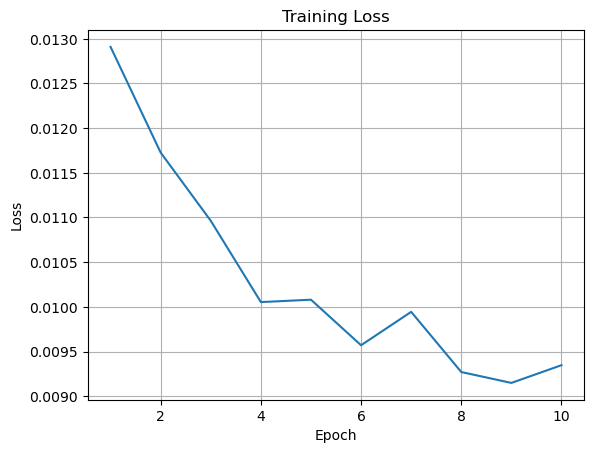

In [12]:
plt.figure()
plt.plot(np.arange(len(mse)) + 1, mse)
plt.grid(which="both")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

### Visualize the original data and reconstructed data

We can now visualize the original audio data and the reconstructed audio data from the autoencoder.
This will help us understand how well the autoencoder has learned to reconstruct the input data from the embeddings.

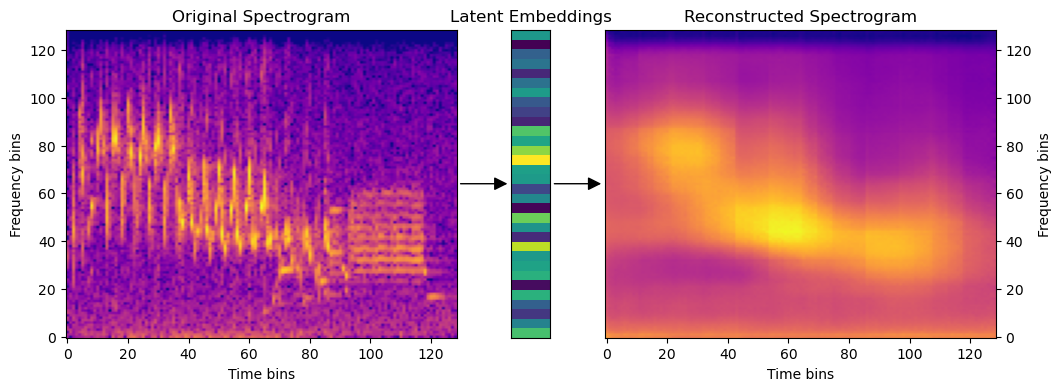

In [22]:
sample_index = 0
with torch.no_grad():
    x, _ = dataset[sample_index]
    x_r, z = autoencoder(x.unsqueeze(0))

fig = plot_input_output(x, z, x_r)
plt.show()

## Part II: Clustering the embedded representations